# BBC Dataset: News Classification
Dataset:https://drive.google.com/open?id=1J93hFfSKX2iqQKhOjHI19d6DSA2DmBSY

Description: http://mlg.ucd.ie/datasets/bbc.html

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Class Labels: 5 (business, entertainment, politics, sport, tech)

In [162]:
import pandas as pd
import numpy as np
def ToDiskP(data,name):
    with open(name+".txt", "wb") as fp:   #Pickling
        pickle.dump(data, fp)
def FromDiskP(name):
    with open(name+".txt", "rb") as fp:   # Unpickling
        file = pickle.load(fp)
    return file

from tqdm import tqdm
import re
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score as f1
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

hparam=[10**-5,10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3, 10**4,10**5]

def BestHparam_(xtr_,ytr_,kfold_,j_,k_): #k-fold: kfold cross validation, j:#jobs to run in parallel
    svm_ = SVC(kernel=k_, random_state=1, decision_function_shape='ovr')
    param_grid = {'C':hparam}
    grid_ = GridSearchCV(svm_, param_grid, n_jobs=j_, scoring='accuracy', cv=kfold_, return_train_score=True)
    grid_.fit(xtr_,ytr_)
    return grid_;


In [96]:
raw_data = pd.read_csv('data/bbc-text.csv')
clean_data=pd.DataFrame(columns=['category','text'])
print(raw_data.shape)
pd.options.display.max_colwidth=5000
print(raw_data.loc[20])
pd.options.display.max_colwidth=50

(2225, 2)
category                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [97]:
%%time
#Ref: https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#Ref: https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


# REFERENCE: https://docs.python.org/3/library/re.html
#Ref: https://www.w3schools.com/python/python_regex.asp
#Ref: https://www.programcreek.com/python/example/99851/nltk.stem.snowball.SnowballStemmer

from bs4 import BeautifulSoup
def ClearText(text):
    text = re.sub(r"http\S+", "",text)
    text = BeautifulSoup(text, 'lxml').get_text()
    text = decontracted(text)
    text = re.sub("\S*\d\S*", "", text).strip()
    text = re.sub('[^a-zA-Z]+', ' ',text)
    #print(text)
    text = ' '.join(e.lower() for e in text.split() if e.lower() not in stopwords and len(e)>2)
    #print(type(text))
    #text = list(text.split())
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer('english')
    stem = []
    for w in text.split():
        w=stemmer.stem(w)
        stem.append(w)
    sentance = " ".join(stem)
    return sentance
    
try:
    clean_data=FromDiskP('preprocessed_data')
    print('Load Successful.')
    
except:
    preprocessed_ = []
    for rv in tqdm(raw_data['text']):
        preprocessed_.append(ClearText(rv))
    clean_data['text']= preprocessed_
    ToDiskP(clean_data,'preprocessed_data')
    print('Save successful.')

Load Successful.
Wall time: 26.9 ms


In [150]:
clean_data['category']=raw_data['category']
clean_data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [101]:
clean_data.head(5)

,category,text
0,tech,futur hand viewer home theatr system plasma hi...
1,business,worldcom boss left book alon former worldcom b...
2,sport,tiger wari farrel gambl leicest say not rush m...
3,sport,yead face newcastl cup premiership side newcas...
4,entertainment,ocean twelv raid box offic ocean twelv crime c...


### Bag of Words

In [159]:
%%time
Y = clean_data['category'].values
X = clean_data['text'].values
from sklearn.model_selection import train_test_split
xtr, xte, ytr, yte = train_test_split(X, Y, test_size=0.3, shuffle=False, random_state=7)
#type(Y)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=5, max_features=5000) 
vectorizer.fit(xtr)
#we use the fitted CountVectorizer to convert the text to vector
xtr_bow = normalize(vectorizer.transform(xtr))
xte_bow = normalize(vectorizer.transform(xte))
print(xtr_bow.shape)

(1557, 5000)
Wall time: 2.05 s


Save successful.
Best C:hyperparameter:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)
Best Score: 0.9749518304431599


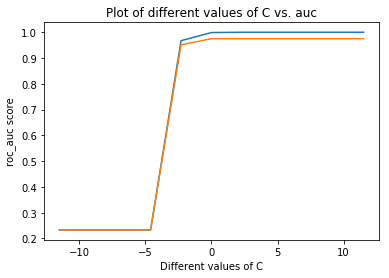


λ Values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

auc Scores: [0.23314066 0.23314066 0.23314066 0.23314066 0.95118818 0.97495183
 0.97495183 0.97495183 0.97495183 0.97495183 0.97495183]
Wall time: 9min


In [141]:
%%time
try:
    grid = FromDiskP('grid_bowl')
    print('Load successful.')
except:
    grid = BestHparam_(xtr_bow,ytr,10,1,'linear')
    ToDiskP(grid,'grid_bowl')
    print('Save successful.')
print("Best C:hyperparameter: ",grid.best_estimator_)
print("Best Score:",(grid.best_score_))
plt.plot(np.log(hparam),grid.cv_results_['mean_train_score'])
plt.plot(np.log(hparam),grid.cv_results_['mean_test_score'])
plt.xlabel('Different values of C')
plt.ylabel('roc_auc score')
plt.title('Plot of different values of C vs. auc')
plt.show()
print('\nλ Values:',hparam)
print('\nauc Scores:',grid.cv_results_['mean_test_score'])

Save successful.
Best C:hyperparameter:  SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)
Best Score: 0.9755940912010276


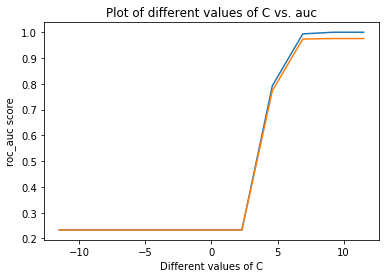


λ Values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

auc Scores: [0.23314066 0.23314066 0.23314066 0.23314066 0.23314066 0.23314066
 0.23314066 0.77328195 0.97366731 0.97559409 0.97559409]
Wall time: 10min 57s


In [143]:
%%time
try:
    grid = FromDiskP('grid_bowr')
    print('Load successful.')
except:
    grid = BestHparam_(xtr_bow,ytr,10,1,'rbf')
    ToDiskP(grid,'grid_bowr')
    print('Save successful.')
print("Best C:hyperparameter: ",grid.best_estimator_)
print("Best Score:",(grid.best_score_))
plt.plot(np.log(hparam),grid.cv_results_['mean_train_score'])
plt.plot(np.log(hparam),grid.cv_results_['mean_test_score'])
plt.xlabel('Different values of C')
plt.ylabel('roc_auc score')
plt.title('Plot of different values of C vs. auc')
plt.show()
print('\nλ Values:',hparam)
print('\nauc Scores:',grid.cv_results_['mean_test_score'])

In [166]:
%%time
print('Bag of Words')
svm_linear = SVC(C=10,kernel='linear', random_state=1)
svm_linear.fit(xtr_bow,ytr)
from sklearn.metrics import accuracy_score
print('Test Accuracy(kernel=linear)\t',accuracy_score(yte,svm_linear.predict(xte_bow)))
svm_rbf = SVC(C=1000,kernel='rbf', random_state=1)
svm_rbf.fit(xtr_bow,ytr)
from sklearn.metrics import accuracy_score
print('Test Accuracy(kernel=rbf)\t',accuracy_score(yte,svm_rbf.predict(xte_bow)))

Bag of Words
Test Accuracy(kernel=linear)	 0.9760479041916168
Test Accuracy(kernel=rbf)	 0.9655688622754491
Wall time: 5.64 s


### TF-IDF

In [163]:
%%time
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidf.fit(xtr)
xtr_tfidf = normalize(tfidf.transform(xtr))
xte_tfidf = normalize(tfidf.transform(xte))

Wall time: 2.07 s


Save successful.
Best C:hyperparameter:  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)
Best Score: 0.9755940912010276


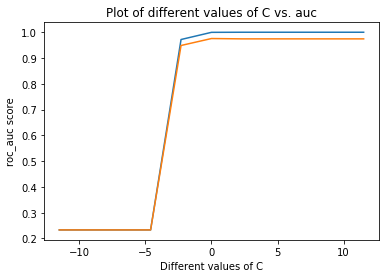


λ Values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

auc Scores: [0.23314066 0.23314066 0.23314066 0.23314066 0.94861914 0.97559409
 0.97430957 0.97430957 0.97430957 0.97430957 0.97430957]
Wall time: 9min 2s


In [164]:
%%time
try:
    grid = FromDiskP('grid_tfidfl')
    print('Load successful.')
except:
    grid = BestHparam_(xtr_tfidf,ytr,10,1,'linear')
    ToDiskP(grid,'grid_tfidfl')
    print('Save successful.')
print("Best C:hyperparameter: ",grid.best_estimator_)
print("Best Score:",(grid.best_score_))
plt.plot(np.log(hparam),grid.cv_results_['mean_train_score'])
plt.plot(np.log(hparam),grid.cv_results_['mean_test_score'])
plt.xlabel('Different values of C')
plt.ylabel('roc_auc score')
plt.title('Plot of different values of C vs. auc')
plt.show()
print('\nλ Values:',hparam)
print('\nauc Scores:',grid.cv_results_['mean_test_score'])

Save successful.
Best C:hyperparameter:  SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)
Best Score: 0.9743095696852923


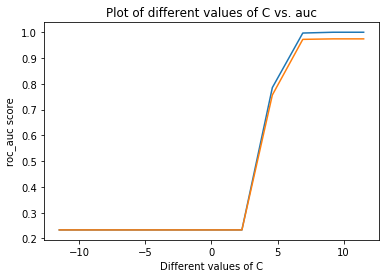


λ Values: [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

auc Scores: [0.23314066 0.23314066 0.23314066 0.23314066 0.23314066 0.23314066
 0.23314066 0.75658317 0.97238279 0.97430957 0.97430957]
Wall time: 11min 1s


In [165]:
%%time
try:
    grid = FromDiskP('grid_tfidfr')
    print('Load successful.')
except:
    grid = BestHparam_(xtr_tfidf,ytr,10,1,'rbf')
    ToDiskP(grid,'grid_tfidfr')
    print('Save successful.')
print("Best C:hyperparameter: ",grid.best_estimator_)
print("Best Score:",(grid.best_score_))
plt.plot(np.log(hparam),grid.cv_results_['mean_train_score'])
plt.plot(np.log(hparam),grid.cv_results_['mean_test_score'])
plt.xlabel('Different values of C')
plt.ylabel('roc_auc score')
plt.title('Plot of different values of C vs. auc')
plt.show()
print('\nλ Values:',hparam)
print('\nauc Scores:',grid.cv_results_['mean_test_score'])

In [169]:
%%time
print('TF-IDF')
svm_linear = SVC(C=1,kernel='linear', random_state=1)
svm_linear.fit(xtr_bow,ytr)
from sklearn.metrics import accuracy_score
print('Test Accuracy(kernel=linear)\t',accuracy_score(yte,svm_linear.predict(xte_bow)))
svm_rbf = SVC(C=10000,kernel='rbf', random_state=1)
svm_rbf.fit(xtr_bow,ytr)
from sklearn.metrics import accuracy_score
print('Test Accuracy(kernel=rbf)\t',accuracy_score(yte,svm_rbf.predict(xte_bow)))
#svm_linear.coef_

TF-IDF
Test Accuracy(kernel=linear)	 0.9700598802395209
Test Accuracy(kernel=rbf)	 0.9760479041916168
Wall time: 5.22 s


### Observations
Result is identical with both vectorizer Bow & TFIDF. Both Linear SVM and RBF kernel gives almost same accuracy(97%) but as we know text data is already high dimension data hence for text data Linear kernel is preferred. RBF takes more time to train compared to Linear SVM, in this example number of datapoints are less so it is not noticable but as number of datapoints will increase Linear SVM will make difference.